###### Importación de las librerías que voy a utilizar a lo largo del script

In [1]:
import pandas as pd
import string
import re
import numpy as np
import matplotlib as plot
import ast
import math

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import heapq

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###### Funciones que voy a utilizar posteriormente para limpiar texto

In [5]:
#Remove punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

#Remove Emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def flatten(lista):
    lista = " ".join(lista)
    return lista

ls = nltk.PorterStemmer()
def stemming(text):
    text = [ls.stem(word) for word in text]
    return text

def change_tod_bin(var):
    if var < 0: var = 0
    else: var = 1
    return var

def lower(text):
    return text.lower()

###### Cargo el Dataset con tweets

In [20]:
df = pd.read_csv('../../Data/TSLA_20190515_20191228.csv', encoding='utf-8-sig') 
#######
#df = df[0:50000] # testado
#######


In [ ]:
#Preparo el Dataset de Tweets
df = df[df['lang'] == "en"]
df.reset_index(inplace = True)
df.drop(["index", "lang"], axis = 1, inplace = True)

In [4]:
df.head()

,date,text,source,hs
0,20190515,RT @frankdonga_: Until you wake up one morning...,Android,15:28
1,20190515,RT @PlainSite: Itâs approaching three days. ...,Deck,15:28
2,20190515,RT @karengeier: run all the military planes on...,iPhone,15:28
3,20190515,@lopezlinette Strange that you call yourself a...,Web Client,15:28
4,20190515,"RT @passthebeano: ""Tesla is a car company. It ...",iPhone,15:28


###### Preparación de la variable de concatenación con el dataset de stocks

In [7]:
df["length"] = df["text"].apply(lambda x: len(x))

df['hour'] = df['hs'].str[0:2]
df['ten_minutes'] = df['hs'].str[3:4]
df['date'] = df['date'].astype(str)
df['month'] = df['date'].apply(lambda x: x[4:6])
df['day'] = df['date'].apply(lambda x: x[6:8])
df['hm'] = df['hs'].apply(lambda x: x[0:2]) + df['hs'].apply(lambda x: x[3:4])

df['timing_concat'] = df['date'] + df['hour'] + df['ten_minutes']

df['RT'] = 1

group_list = ['timing_concat','text', 'length', 'source', 'date', 'month', 'day', 'hm', 'hour']
agg_list = ['RT']
df = df.groupby(group_list, as_index = False)[agg_list].sum().reset_index()
df = df[['timing_concat','text', 'RT','length', 'source', 'date', 'month', 'day', 'hm', 'hour']]
df.sort_values("timing_concat", ascending = False, inplace = True)

###### Saco más info del texto

In [8]:
df["n_mentions"] = df["text"].str.count(r'@\S+')
df["elon_mentions"] = df["text"].str.count(r'@elonmusk')
df["tesla_mentions"] = df["text"].str.count(r'@Tesla')
df["link"] = df["text"].str.count(r'http\S+')

###### Limpieza del texto

In [9]:
def text_clean(df, feature):
    df = df.copy(deep=True)
    df["text"] = df["text"].str.replace(r'\n','', case = False)
    df["text"] = df["text"].str.replace(r'\r','', case = False)
    df['text'] = df[feature].str.encode('ascii', 'ignore').str.decode('ascii')
    # lowering debe ser siempre lo primero de todo
    df['text'] = df['text'].str.lower()
    #Remove Links
    df['text'] = df['text'].str.replace('http\S+', '', case=False)
    #Remove Mentions @
    df['text'] = df['text'].str.replace('@\S+', '', case=False)
    #Remove RT
    #'\bRT\b'
    df['text'] = df['text'].str.replace(r'\bRT\b', '', case = True)
    df['text'] = df['text'].str.replace(r'\brt\b', '', case = True)
    df['text'] = df['text'].apply(lambda x: remove_punct(x))
    df['text'] = df['text'].apply(lambda x: remove_emoji(x))
    #Para que tsla y Tesla no cuenten como dos palabras (muy frecuente), igualamos a tesla.
    df['text'] = df['text'].str.replace(r'\btsla\b', '', case = True)
    df['text'] = df['text'].str.replace(r'\tesla\b', '', case = True)
    df['clean_text'] = df['text']
    return df['clean_text']

df['clean_text'] = text_clean(df, 'text')

###### Agrego registros por la variable Timing Concat

In [10]:
df_processed = pd.DataFrame(columns=['timing_concat','tweets', 'tweet_count', 'length', 'n_mentions',
                                    'elon_mentions', 'tesla_mentions', 'link', 'RT'])

#sacamos una lista iter_timing_concat de valores únicos
iter_timing_concat = df['timing_concat'].unique()
#iteramos sobre iter_timing_concat
for j in range(0,len(iter_timing_concat)):
    timing_concat = iter_timing_concat[j]
    x = df[df['timing_concat'] == timing_concat]
    #n_agg = len(x) #  + x["RT"].sum()
    tweets = x['clean_text'].to_list()
    
    
    df_processed.loc[j] = pd.Series({'timing_concat':timing_concat,
                                     'tweets':tweets,
                                     'tweet_count': x["RT"].sum(),
                                     'length': x['length'].mean(axis = 0),
                                     'n_mentions': x["n_mentions"].sum(),
                                     'elon_mentions': x["elon_mentions"].sum(),
                                     'tesla_mentions': x["tesla_mentions"].sum(),
                                     'link': x["link"].sum(),
                                     #'n_agg':n_agg,
                                     'RT': x["RT"].sum()
                                    })
    
df_processed.sort_values("timing_concat", inplace = True)

In [11]:
df_processed["tweets"][0][0]

' day ahead top  things to watch  spy qqq dis fb amzn aapl  roku trade'

###### La bolsa abre de 15.30 a 22h. Todos los tweets entre las 00.00h y las 15.30, los acumulamos en el registro de las 15.30h.
De esta manera, no perdemos la información de antes de la apertura de bolsa.

In [9]:
"""def below_153(x):
    x = int(x)
    if x < 153:   #Es decir, es un tweetde antes de las 15.30h (apertura de bolsa)
        return "153"
    else:
        return x
    
df_processed["date"] = df_processed['timing_concat'].apply(lambda x: x[0:8])
df_processed["hm"] = df_processed['timing_concat'].apply(lambda x: x[8:11])

df_processed['hm'] = df_processed['hm'].apply(lambda x: below_153(x)) 

#Actualizo el valor de timing_concat
df_processed["timing_concat"] = df_processed["date"].astype(str) + df_processed["hm"].astype(str)

df_processed2 = pd.DataFrame(columns=['timing_concat','tweets', 'tweet_count', 'length', 'n_mentions',
                                    'elon_mentions', 'tesla_mentions', 'link', 'n_agg', 'RT'])

#sacamos una lista iter_timing_concat de valores únicos
iter_timing_concat = df_processed['timing_concat'].unique()
#iteramos sobre iter_timing_concat

for j in range(0,len(iter_timing_concat)):
    timing_concat = iter_timing_concat[j]
    # hacemos un subset del periodo de 10 minutos sobre el cual vamos a ejecutar la operación
    x = df_processed[df_processed['timing_concat'] == timing_concat]
    
    # para hacer el modelo, necesitamos el nuevo dataset de 2 columnas: tweets y tiempo
    # tiempo es precisamente nuestro timing_concat
    # tweets qué es? en esta parte del bucle for:
    tweets = x['tweets'].to_list()
    n_agg = len(x["timing_concat"]) 
    
    df_processed2.loc[j] = pd.Series({'timing_concat':timing_concat,
                                     'tweets':tweets,
                                     'tweet_count': x["tweet_count"].sum(),
                                     'length': int(x["length"].mean(axis = 0)),
                                     'n_mentions': x["n_mentions"].sum(),
                                     'elon_mentions': x["elon_mentions"].sum(),
                                     'tesla_mentions': x["tesla_mentions"].sum(),
                                     'link': x["link"].sum(),
                                     'n_agg':n_agg,
                                     'RT': x["RT"].sum()
                                    })
    """

'def below_153(x):\n    x = int(x)\n    if x < 153:   #Es decir, es un tweetde antes de las 15.30h (apertura de bolsa)\n        return "153"\n    else:\n        return x\n    \ndf_processed["date"] = df_processed[\'timing_concat\'].apply(lambda x: x[0:8])\ndf_processed["hm"] = df_processed[\'timing_concat\'].apply(lambda x: x[8:11])\n\ndf_processed[\'hm\'] = df_processed[\'hm\'].apply(lambda x: below_153(x)) \n\n#Actualizo el valor de timing_concat\ndf_processed["timing_concat"] = df_processed["date"].astype(str) + df_processed["hm"].astype(str)\n\ndf_processed2 = pd.DataFrame(columns=[\'timing_concat\',\'tweets\', \'tweet_count\', \'length\', \'n_mentions\',\n                                    \'elon_mentions\', \'tesla_mentions\', \'link\', \'n_agg\', \'RT\'])\n\n#sacamos una lista iter_timing_concat de valores únicos\niter_timing_concat = df_processed[\'timing_concat\'].unique()\n#iteramos sobre iter_timing_concat\n\nfor j in range(0,len(iter_timing_concat)):\n    timing_concat = i

### Datos Stock
Sólo nos quedamos con los registros en los que la bolsa esté abierta. Para ello, importamos nuestro dataset con datos de stock.

In [18]:
df_stock = pd.read_csv('../../Data/TSLA.USUSD_Candlestick_1_M_BID_01.05.2019-01.02.2020.csv', index_col=None
                 , header=1
                 , encoding='utf-8' #'ISO-8859-1'
                 #, usecols=[0, 1, 2, 4]
                 , names=['date_time', 'open', 'high', 'low', 'close', 'volume'])
df_stock.head()

,date_time,open,high,low,close,volume
0,01.05.2019 00:01:00.000 GMT+0200,238.677,238.677,238.677,238.677,0.0
1,01.05.2019 00:02:00.000 GMT+0200,238.677,238.677,238.677,238.677,0.0
2,01.05.2019 00:03:00.000 GMT+0200,238.677,238.677,238.677,238.677,0.0
3,01.05.2019 00:04:00.000 GMT+0200,238.677,238.677,238.677,238.677,0.0
4,01.05.2019 00:05:00.000 GMT+0200,238.677,238.677,238.677,238.677,0.0


In [13]:
df_stock = pd.read_csv('../../Data/TSLA.USUSD_Candlestick_1_M_BID_01.05.2019-01.02.2020.csv', index_col=None
                 , header=1
                 , encoding='utf-8' #'ISO-8859-1'
                 #, usecols=[0, 1, 2, 4]
                 , names=['date_time', 'open', 'high', 'low', 'close', 'volume'])

# openning hours in market is defined by volume != 0
df_stock = df_stock[df_stock['volume'] != 0]
#df_stock = df_stock[0:2000]

df_stock['day'] = df_stock['date_time'].apply(lambda x: x[:2])
df_stock['month'] = df_stock['date_time'].apply(lambda x: x[3:5])
df_stock['year'] = df_stock['date_time'].apply(lambda x: x[6:10])
df_stock['date'] = df_stock['year'] + df_stock['month'] + df_stock['day']
df_stock['hour'] = df_stock['date_time'].apply(lambda x: x[11:13])
df_stock['ten_minutes'] = df_stock['date_time'].apply(lambda x: x[14:15])
df_stock['minute'] = df_stock['date_time'].apply(lambda x: x[15:16])

df_stock['timing_concat'] = df_stock['date'] + df_stock['hour'] + df_stock['ten_minutes']

iter_timing_concat = df_stock['timing_concat'].unique()
dfs_processed = pd.DataFrame(columns=['timing_concat', 'open','close', 'low', 'high', 'volume'])

for j in range(0,len(iter_timing_concat)):
    timing_concat = iter_timing_concat[j]
    # hacemos un subset del periodo de 10 minutos sobre el cual vamos a ejecutar la operación
    x = df_stock[df_stock['timing_concat'] == timing_concat]

    #tweets = x['clean_text'].to_list()
    
    open_price = x['open'].iloc[0]
    close_price = x['close'].iloc[-1]
    low_price = x['low'].min()
    high_price = x['high'].max()
    volume = x['volume'].sum()
    
    dfs_processed.loc[j] = pd.Series({'timing_concat':timing_concat,
                                      'open':open_price,
                                      'close': close_price,
                                      'low': low_price,
                                      'high': high_price,
                                      'volume': volume
                                    })
    


In [15]:
df_stock.head()

,date_time,open,high,low,close,volume,day,month,year,date,hour,ten_minutes,minute,timing_concat
929,01.05.2019 15:30:00.000 GMT+0200,238.787,238.837,237.688,237.747,0.0110,01,05,2019,20190501,15,3,0,20190501153
930,01.05.2019 15:31:00.000 GMT+0200,237.747,237.748,237.287,237.588,0.0071,01,05,2019,20190501,15,3,1,20190501153
931,01.05.2019 15:32:00.000 GMT+0200,237.570,237.570,236.877,237.157,0.0020,01,05,2019,20190501,15,3,2,20190501153
932,01.05.2019 15:33:00.000 GMT+0200,237.207,237.588,237.157,237.587,0.0018,01,05,2019,20190501,15,3,3,20190501153
933,01.05.2019 15:34:00.000 GMT+0200,237.587,237.908,237.337,237.338,0.0018,01,05,2019,20190501,15,3,4,20190501153


###### Hago merge de los dos datasets por la variable timing_concat

In [11]:
df = pd.merge(left=df_processed, right=dfs_processed, left_on='timing_concat', right_on='timing_concat')
df.head()

,timing_concat,tweets,tweet_count,length,n_mentions,elon_mentions,tesla_mentions,link,RT,open,close,low,high,volume
0,20190515153,"[ um have you heard of , help my gui is goo...",155,113.402685,304,12,41,90,155,229.238,226.898,226.557,229.667,0.0997
1,20190515154,[cars will change more in the next decade than...,207,122.841026,300,15,41,148,207,226.898,226.897,225.227,227.328,0.1783
2,20190515155,[car expo info there are many misconceptions a...,198,121.530928,267,14,39,130,198,226.927,227.537,226.207,227.888,0.1280
3,20190515160,[amazing thread demonstrates how corporate cri...,197,117.746032,218,15,37,132,197,227.538,227.597,227.267,228.928,0.0927
4,20190515161,[ev for sale tesla model s d hatchback awd of...,177,119.710059,257,21,28,109,177,227.597,230.422,226.867,231.408,0.1421


In [12]:
print(f"Df Tweets desde: {df_processed['timing_concat'].min()}")
print(f"Df Tweets hasta: {df_processed['timing_concat'].max()}")
print("\n")
print(f"Df Stock desde: {dfs_processed['timing_concat'].min()}")
print(f"Df Stock hasta: {dfs_processed['timing_concat'].max()}")

Df Tweets desde: 20190515152
Df Tweets hasta: 20191218131


Df Stock desde: 20190501153
Df Stock hasta: 20200131215


In [13]:
df.reset_index(inplace = True)
df.sort_values("timing_concat", ascending = True, inplace  = True)

Calculo la variación en bolsa, si sube (1) o baja (0)

In [14]:
def change_tod_bin(var):
    if var < 0: var = 0
    else: var = 1
    return var

df['Change_tod'] = df['close']-df['open']
df['CLASE'] = df['Change_tod'].apply(lambda x: change_tod_bin(x))

In [15]:
df.head()

,index,timing_concat,tweets,tweet_count,length,n_mentions,elon_mentions,tesla_mentions,link,RT,open,close,low,high,volume,Change_tod,CLASE
0,0,20190515153,"[ um have you heard of , help my gui is goo...",155,113.402685,304,12,41,90,155,229.238,226.898,226.557,229.667,0.0997,-2.340,0
1,1,20190515154,[cars will change more in the next decade than...,207,122.841026,300,15,41,148,207,226.898,226.897,225.227,227.328,0.1783,-0.001,0
2,2,20190515155,[car expo info there are many misconceptions a...,198,121.530928,267,14,39,130,198,226.927,227.537,226.207,227.888,0.1280,0.610,1
3,3,20190515160,[amazing thread demonstrates how corporate cri...,197,117.746032,218,15,37,132,197,227.538,227.597,227.267,228.928,0.0927,0.059,1
4,4,20190515161,[ev for sale tesla model s d hatchback awd of...,177,119.710059,257,21,28,109,177,227.597,230.422,226.867,231.408,0.1421,2.825,1


In [16]:
"""
#df["tweets"] = df["tweets"].apply(lambda x : [item for sublist in x for item in sublist])
df["tweets"] = df["tweets"].apply(lambda x : [item for sublist in x for item in sublist])
df['tweets'] = df['tweets'].apply(lambda y: " ".join(y))
"""

'\n#df["tweets"] = df["tweets"].apply(lambda x : [item for sublist in x for item in sublist])\ndf["tweets"] = df["tweets"].apply(lambda x : [item for sublist in x for item in sublist])\ndf[\'tweets\'] = df[\'tweets\'].apply(lambda y: " ".join(y))\n'

###### Borramos los registros del día 12 de noviembre por error en recogida de datos.
Registros de minuto y hora a cero

In [17]:
df["date"] = df['timing_concat'].apply(lambda x: x[0:8])
df.drop(df[df['date']=='20191112'].index, axis=0, inplace=True)

###### Limpio de StopWords, y me quedo con la raíz de las palabras
https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/

In [18]:
df["tweets"]= df["tweets"].astype(str)

In [19]:
# stop.insert(0, ["rt","tesla", "tsla", "tsl"])    #Creo que esto no ha funcionado

In [20]:
#df['tweets'] = df['tweets'].apply(lambda y: " ".join(y))
#Tokenizo
df['tweets'] = df['tweets'].apply(lambda x: nltk.word_tokenize(x))
#Limpio 'text' de stopwords
df['tweets'] = df['tweets'].apply(lambda x: ' '.join([word for word in x if word not in stop]))
#Tokenizo
df['tweets'] = df['tweets'].apply(lambda x: nltk.word_tokenize(x))
#Ahora "normalizo" el texto tokenizado.
#Hacemos Stemming (sacamos la raíz de cada palabra). 
  #LancasterStemmer me acorta mucho la raíz, es un poco... "agresivo"
  #Pruebo con el de Porter
df['tweets'] = df['tweets'].apply(lambda x: stemming(x))
df['tweets'] = df['tweets'].apply(lambda y: " ".join(y))


In [21]:
df.head()

,index,timing_concat,tweets,tweet_count,length,n_mentions,elon_mentions,tesla_mentions,link,RT,open,close,low,high,volume,Change_tod,CLASE,date
0,0,20190515153,"[ ' um heard ' , ' help gui gooey ' , ' could ...",155,113.402685,304,12,41,90,155,229.238,226.898,226.557,229.667,0.0997,-2.340,0,20190515
1,1,20190515154,"[ 'car chang next decad past centuri ' , ' rig...",207,122.841026,300,15,41,148,207,226.898,226.897,225.227,227.328,0.1783,-0.001,0,20190515
2,2,20190515155,[ 'car expo info mani misconcept ev like tesla...,198,121.530928,267,14,39,130,198,226.927,227.537,226.207,227.888,0.1280,0.610,1,20190515
3,3,20190515160,[ 'amaz thread demonstr corpor crimin like elo...,197,117.746032,218,15,37,132,197,227.538,227.597,227.267,228.928,0.0927,0.059,1,20190515
4,4,20190515161,[ 'ev sale tesla model hatchback awd leas tesl...,177,119.710059,257,21,28,109,177,227.597,230.422,226.867,231.408,0.1421,2.825,1,20190515


In [22]:
df.to_csv("df_intermedio1.csv")

In [429]:
df = pd.read_csv("df_intermedio1.csv")

###### PROBLEMA: Hay un registro que no me lo reconoce con ast.literal_eval(). 
Para salir al paso me cargo el texto y le pongo "Tesla". Tiene que tener algún caracter raro.

# Creo que esto ya está solucionado. Chequear.

In [430]:
df.head(1)

,Unnamed: 0,index,timing_concat,tweets,tweet_count,length,n_mentions,elon_mentions,tesla_mentions,link,RT,open,close,low,high,volume,Change_tod,CLASE,date
0,0,0,20190515153,"[ ' um heard ' , ' help gui gooey ' , ' could ...",155,113.402685,304,12,41,90,155,229.238,226.898,226.557,229.667,0.0997,-2.34,0,20190515


In [431]:
def literal(x):
    try:
        return ast.literal_eval(x)
    except:
        #x.str.split(',')
        x = "TESLA"
        """caso = x.replace('[', "")
        caso = caso.replace(']', "")
        caso = caso.replace("' ", "")
        caso = caso.replace(" '", "")"""
        return x
        
df["tweets"] = df["tweets"].apply(lambda x: literal(x))    

In [423]:
caso = df["tweets"][2533].replace('[', "")
caso = caso.replace(']', "")
caso = caso.replace("' ", "")
caso = caso.replace(" '", "")

In [424]:
lista = caso.split(",")

In [425]:
lista[0]

'hey tesla deliveri '

In [323]:
df.head(1)

,Unnamed: 0,index,timing_concat,tweets,tweet_count,length,n_mentions,elon_mentions,tesla_mentions,link,RT,open,close,low,high,volume,Change_tod,CLASE,date
0,0,0,20190515153,"[ um heard , help gui gooey , could also dis...",155,113.402685,304,12,41,90,155,229.238,226.898,226.557,229.667,0.0997,-2.34,0,20190515


# Resumen de contenido de Tweets.
https://towardsdatascience.com/text-summarization-using-tf-idf-e64a0644ace3

In [432]:
def _create_frequency_matrix(sentences):
    frequency_matrix = {}

    for sent in sentences:
        freq_table = {}
        words = word_tokenize(sent)
        #print(words)
        for word in words:
            if word in freq_table:
                freq_table[word] += 1
            else:
                freq_table[word] = 1

        frequency_matrix[sent[:15]] = freq_table
        
    return frequency_matrix

def _create_tf_matrix(freq_matrix):
    tf_matrix = {}

    for sent, f_table in freq_matrix.items():
        tf_table = {}

        count_words_in_sentence = len(f_table)
        for word, count in f_table.items():
            tf_table[word] = count / count_words_in_sentence

        tf_matrix[sent] = tf_table

    return tf_matrix

def _create_documents_per_words(freq_matrix):
    word_per_doc_table = {}

    for sent, f_table in freq_matrix.items():
        for word, count in f_table.items():
            if word in word_per_doc_table:
                word_per_doc_table[word] += 1
            else:
                word_per_doc_table[word] = 1

    return word_per_doc_table

def _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents):
    idf_matrix = {}

    for sent, f_table in freq_matrix.items():
        idf_table = {}

        for word in f_table.keys():
            idf_table[word] = math.log10(total_documents / float(count_doc_per_words[word]))

        idf_matrix[sent] = idf_table

    return idf_matrix

def _create_tf_idf_matrix(tf_matrix, idf_matrix):
    tf_idf_matrix = {}

    for (sent1, f_table1), (sent2, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):

        tf_idf_table = {}

        for (word1, value1), (word2, value2) in zip(f_table1.items(),
                                                    f_table2.items()):  # here, keys are the same in both the table
            tf_idf_table[word1] = float(value1 * value2)

        tf_idf_matrix[sent1] = tf_idf_table

    return tf_idf_matrix

def _score_sentences(tf_idf_matrix) -> dict:
    """
    score a sentence by its word's TF
    Basic algorithm: adding the TF frequency of every non-stop word in a sentence divided by total no of words in a sentence.
    :rtype: dict
    """

    sentenceValue = {}

    for sent, f_table in tf_idf_matrix.items():
        total_score_per_sentence = 0

        count_words_in_sentence = len(f_table)
        for word, score in f_table.items():
            total_score_per_sentence += score

        sentenceValue[sent] = total_score_per_sentence / count_words_in_sentence

    return sentenceValue

def _find_average_score(sentenceValue) -> int:
    """
    Find the average score from the sentence value dictionary
    :rtype: int
    """
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    # Average value of a sentence from original summary_text
    average = (sumValues / len(sentenceValue))

    return average

def _generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = ''

    for sentence in sentences:
        if sentence[:15] in sentenceValue and sentenceValue[sentence[:15]] >= (threshold):
            summary += " " + sentence
            sentence_count += 1

    return summary

In [433]:
def resumen(x):
    try:
        text = '. '.join(sent for sent in x)
        sentences = sent_tokenize(text)
        total_documents = len(sentences)

        freq_matrix = _create_frequency_matrix(sentences)
        tf_matrix = _create_tf_matrix(freq_matrix)
        count_doc_per_words = _create_documents_per_words(freq_matrix)
        idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)
        tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)
        sentence_scores = _score_sentences(tf_idf_matrix)
        threshold = _find_average_score(sentence_scores)
        summary = _generate_summary(sentences, sentence_scores, 1.3 * threshold)
    except:
        summary = "TESLA"
    
    #En caso de querer resumirlo más, podemos modificar el factor que multiplica al threshold.
    return summary
    
df["resumen"] = df["tweets"].apply(lambda x: resumen(x))

In [435]:
df["tweets"][1]

['car chang next decad past centuri ',
 ' right everyth go sideway consolid tri figur want go furth ',
 ' right tesla doubl bottom w may becom wv doubl bottom anoth hi ',
 'anoth tesla catch fire park lot news amp opinion ',
 'clueless catalyst market rapidli repric tesla risk market cap inevit ',
 'check articl switch electr make sens electricvehicl ev tesla gogreen ',
 'check ev infrastructur instal featur del condominium magazin evinfrastructur evcondo evdriv ',
 'chines compani develop hell electr car jd ctrp uber tesla ',
 'citi fremont home tesla factori state largest ev owner zip code ',
 ' hey that noth asham tesla dashboard minimalist lightweight text ',
 ' nflx role model tesla could pop im still tempt reenter put ',
 ' tesla model base specif autopilot recommend ',
 ' ',
 ' stop use autopilot your go kill someon ',
 ' gameev ca ',
 ' cri help got squeez tesla fanboy crazi havent seen vegan investor ',
 ' mat couldnt make sleek look like tesla would pick tesla ',
 ' realli wo

In [434]:
df["resumen"][1]

' gameev ca . realli wow . it amaz tesla bid b . love big batteri cant lie . oh that bummer . shit happen . everyon alright . th . parent name babi tesla . confirm speak wish africa expo . wmt look wmt tesla moment . exactli . see . offer teacher discount . smoke crack cocain fire employe . tesla poor invest . solar roof china . tesla insur program interest . should use powerwal . tesla powerpoint present powerpoint present minimalist graphicdesign tesla graphic .'

Veo que no debe de estar funcionando bien la limpieza de texto. Hay RTs, Tesla. Revisar código

In [327]:
"""def juntar(x):
    try:
        return " ".join(y)
    except:
        return ""
df["tweets"] = df["tweets"].apply(lambda y: juntar(y))"""

'def juntar(x):\n    try:\n        return " ".join(y)\n    except:\n        return ""\ndf["tweets"] = df["tweets"].apply(lambda y: juntar(y))'

In [328]:
df["tweets"] = df["tweets"].apply(lambda y: " ".join(y))

Calculo la longitud media del corpus de cada 10 minutos.

In [329]:
df["lon"] = 0
lon = 0
for i in range(0, len(df)):
    lon = lon + len(df["tweets"][i].split())
    
df["lon"] = df["tweets"].apply(lambda x: len(x.split()))
avg_lon = int(lon / len(df["tweets"]))
print(avg_lon)

2283


In [330]:
df["lon_resumen"] = 0
lon = 0
for i in range(0, len(df)):
    lon = lon + len(df["resumen"][i].split())
    
df["lon_resumen"] = df["resumen"].apply(lambda x: len(x.split()))
avg_lon = int(lon / len(df["resumen"]))
print(avg_lon)

182


######  Aislo los registros que son demasiado largos, y hago un resumen de cada uno

En la siguiente celda, nos quedamos sólo con el top 50 palabras de cada registro. No es una lista de palabras únicas, porque nos interesa ver la frecuencia de cada palabra.

In [331]:
df["date"] = df["date"].astype(str)

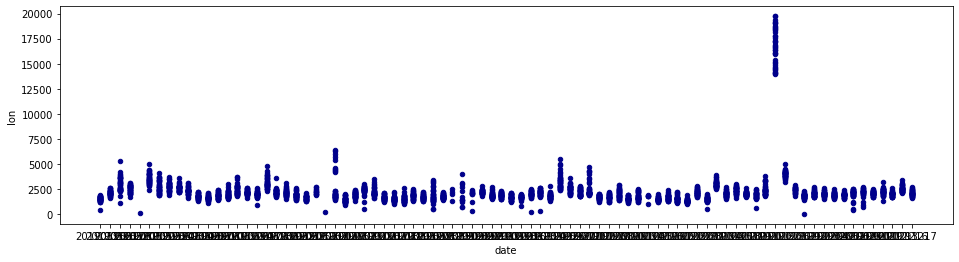

In [339]:
ax1 = df.plot.scatter(x='date',
                      y='lon',
                      c='DarkBlue',
                      figsize=(16, 4))

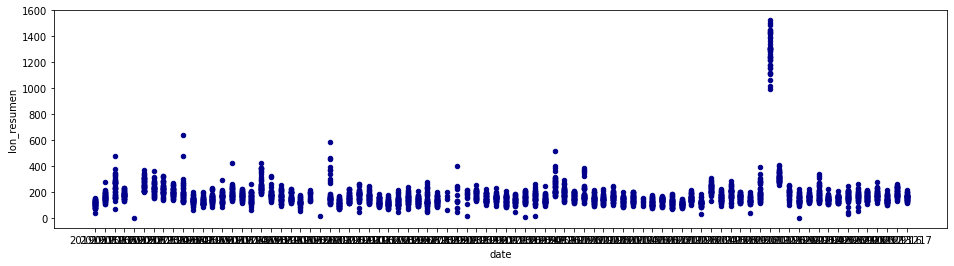

In [340]:
ax1 = df.plot.scatter(x='date',
                      y='lon_resumen',
                      c='DarkBlue',
                      figsize=(16, 4))

El Outlier corresponde al día de presentación del Cybertruck. Deberíamos eliminar outliers? Perder esa información? En realidad me está generando términos muy frecuentes en relación al lenguaje común

##### Análisis de la frecuencia de las palabras

In [341]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [342]:
#Quitamos las palabras que aparezcan menos de 5 veces en cada registro, y las que aparecen en más del 90%
cvec = CountVectorizer(stop_words='english', min_df=0.25, max_df=.9, ngram_range=(1,3))
cvec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=0.25,
                ngram_range=(1, 3), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [343]:
# Calculate all the n-grams found in all documents
from itertools import islice
cvec.fit(df.resumen)
list(islice(cvec.vocabulary_.items(), 20))

[('lol', 12),
 ('like', 11),
 ('dont', 3),
 ('drive', 4),
 ('tslaq', 25),
 ('love', 14),
 ('look', 13),
 ('buy', 0),
 ('thank', 21),
 ('ye', 27),
 ('think', 23),
 ('know', 10),
 ('right', 20),
 ('elon', 5),
 ('want', 26),
 ('im', 9),
 ('model', 16),
 ('good', 7),
 ('need', 17),
 ('thi', 22)]

In [344]:
#Número de valores únicos
len(cvec.vocabulary_)

28

In [345]:
cvec_counts = cvec.transform(df.resumen)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (2961, 28)
nonzero count: 27274
sparsity: 32.90%


###### 20 registros más comunes

In [346]:
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
1,car,2135
11,like,2014
19,pleas,1952
21,thank,1927
14,love,1850
9,im,1825
22,thi,1755
13,look,1692
17,need,1683
7,good,1508


##### Top 20 terms by average tf-idf weight

In [347]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<2961x28 sparse matrix of type '<class 'numpy.float64'>'
	with 27274 stored elements in Compressed Sparse Row format>

In [348]:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
1,car,0.130495
21,thank,0.124474
11,like,0.123922
14,love,0.116909
9,im,0.110888
17,need,0.109471
7,good,0.106523
22,thi,0.106237
25,tslaq,0.105435
16,model,0.104632


Elimino los registros de un sólo caracter que han quedado. No creo que tengan sentido. Además, elimino las puntuaciones que he añadido en el resumen.

In [349]:
def text_clean(df, feature):
    df = df.copy(deep=True)
    df['resumen'] = df[feature].str.encode('ascii', 'ignore').str.decode('ascii')
    df['resumen'] = df['resumen'].str.replace(r'\rt\b', '', case = True)
    df['resumen'] = df['resumen'].apply(lambda x: remove_punct(x))
    #Para que tsla y Tesla no cuenten como dos palabras (muy frecuente), igualamos a tesla.
    df['resumen'] = df['resumen'].str.replace(r'\btsla\b', "", case = True)
    df['resumen'] = df['resumen'].str.replace(r'\btesla\b', "",  case = True)
    
    return df['resumen']

df['resumen'] = text_clean(df, 'resumen')

In [353]:
df.to_csv("..\Data\TSLA_stock_tweets.csv")